## Name: Vatsal Vinay Parikh


##

**Train word2vec representation embeddings on a large news corpus (>1B tokens) using. Be patient during training and manage your code efficiently to avoid running lengthy processes multiple times. Adjust configurations according to your understanding, including vocabulary size (n_vocab), embedding size (n_embed), learning rate, number of negative examples per positive example, and window size. Experiment with different settings to develop your intuition. Note that the dataset size is limited to 150K documents.**

In [ ]:
import numpy as np
import pandas as pd
import random
import torch
from nltk.corpus import stopwords
from collections import Counter

from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
from collections import OrderedDict
from nltk.corpus import stopwords

from torch import nn
from torch.functional import F
from torch import optim
from tqdm import tqdm

In [ ]:
def tokenize_doc(sent,
                 lemma=False,
                 remove_stopwords=False):

    # a simple tokenizer with case folding and an option to use lemmatization
    sent = sent.lower()
    tokens = sent.split()
    if lemma:
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    if remove_stopwords:

        tokens = [token for token in tokens if token not in stopwords.words('english')]
    return tokens

def basic_text_processing(corpus, num_words):
    #output the vocabulary as a dictionary (w2i and i2w or word2index and index2word)
    #output train_tokens, which is the sequence of ALL tokens of ALL sentences in the corpus.
    #basically, we will just concatenate all tokens in the corpus together
    vocab = set()
    all_tokens = []

    # tokenization
    for doc in tqdm(corpus):
        tokens = tokenize_doc(doc, lemma=False, remove_stopwords=False)
        vocab.update(set(tokens))
        all_tokens.extend(tokens) #concatenate all tokens in the corpus together

    # TODO START
    # We only want to train with the top num_words MOST FREQUENT words
    # Output a variable called ``train_tokens" that is similar to all_tokens
    # variable but WITHOUT infrequent words

    # Count word frequencies
    word_counts = Counter(all_tokens)
    # Get the most common num_words
    most_common_words = set([word for word, _ in word_counts.most_common(num_words)])
    # Filter out tokens not in the top num_words
    train_tokens = [token for token in all_tokens if token in most_common_words]

    # TODO END

    # generating vocabulary from the train_tokens
    word_counts = Counter(train_tokens)
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    i2w = {ii: word for ii, word in enumerate(sorted_vocab)}
    w2i = {word: ii for ii, word in i2w.items()}

    return w2i, i2w, train_tokens

In [ ]:
def get_targets(words, idx, window_size=5):
    R = random.randint(1, 5)
    start = max(0,idx-R)
    end = min(idx+R,len(words)-1)
    targets = words[start:idx] + words[idx+1:end+1] # +1 since doesn't include this idx
    return targets

In [ ]:
def get_batches(words, batch_size, window_size = 5):
    for i in range(0, len(words), batch_size):
        curr = words[i:i + batch_size]   # current batch
        batch_x, batch_y = [], []

        for ii in range(len(curr)):
            x = [curr[ii]]
            y = get_targets(curr, ii)
            batch_x.extend(x * len(y))
            batch_y.extend(y)

        yield batch_x, batch_y

In [ ]:
!pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.8 MB/s eta 0:00:00


In [ ]:
#CC-News dataset contains news articles from news sites all over the world.
#The data is available on AWS S3 in the Common Crawl bucket at /crawl-data/CC-NEWS/.
#This version of the dataset has been prepared using news-please - an integrated web crawler and information extractor for news.
#It contains 708241 English language news articles published between Jan 2017 and December 2019.
#It represents a small portion of the English language subset of the CC-News dataset.

from datasets import load_dataset
dataset = load_dataset("cc_news")
corpus = dataset['train']['text'][:150000]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.57k [00:00<?, ?B/s]

train-00000-of-00005.parquet:   0%|          | 0.00/211M [00:00<?, ?B/s]

train-00001-of-00005.parquet:   0%|          | 0.00/234M [00:00<?, ?B/s]

train-00002-of-00005.parquet:   0%|          | 0.00/219M [00:00<?, ?B/s]

train-00003-of-00005.parquet:   0%|          | 0.00/245M [00:00<?, ?B/s]

train-00004-of-00005.parquet:   0%|          | 0.00/215M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/708241 [00:00<?, ? examples/s]

In [ ]:
n_vocab = 5000  # maximum size of vocab (adjust this based on memory and dataset size)
n_embed = 8    # size of embedding (common values are 100, 200, 300)
lr = 0.01        # learning rate (1.0 may be too high; 0.01 is often a good starting point)
n_negative_samples = 5  # number of negative examples per positive example (common values are 5-20)
ws = 5           # window size for context words (5 is a common default)
batch_size = 512 # batch size for sampling positive examples (depends on available memory, 512 is a good start)
n_epochs = 3     # number of training epochs (experiment with this, 3-10 is a typical range)
device = 'cpu'   # 'cuda' if you have a GPU available, otherwise 'cpu'

- `n_vocab = 5000`: Limits the vocabulary size to 5000 words to manage memory usage effectively.
- `n_embed = 8`: Uses a small embedding size (8) to reduce computational requirements during training.
- `lr = 0.01`: Sets the learning rate to 0.01 for stable gradient descent updates.
- `n_negative_samples = 5`: Chooses 5 negative samples per positive example to improve training with negative sampling.
- `ws = 5`: Sets the context window size to 5, a common choice for capturing surrounding word context.
- `batch_size = 512`: Uses a batch size of 512 to balance memory usage and training speed.
- `n_epochs = 3`: Runs training for 3 epochs to prevent overfitting while allowing sufficient learning.
- `device = 'cpu'`: Uses CPU for training due to the lack of a GPU or memory limitations.


In [ ]:
# this cell might take 20 minutes to run, so be patient!
# optional: you might want to save these intermediate results to disk
# so that next time you open Google Colab, you don't need to
# run this again
w2i, i2w, train_tokens = basic_text_processing(corpus, num_words=n_vocab)
int_words = [w2i[token] for token in train_tokens]
print("Vocab Size:", len(w2i))

100%|██████████| 150000/150000 [00:43<00:00, 3419.41it/s]


Vocab Size: 5000


### Training

In [ ]:
def train_skipgram(W,
                   C,
                   int_words,
                   n_vocab,
                   n_embed,
                   learning_rate,
                   n_negative_samples,
                   batch_size,
                   window_size,
                   n_epochs,
                   print_every=100):

    optimizer = optim.Adam([W, C], lr=learning_rate)

    W = torch.nn.init.uniform_(W, -0.10, +0.10)
    C = torch.nn.init.uniform_(C, -0.10, +0.10)

    step = 0

    for epoch in range(n_epochs):
        for inputs, targets in get_batches(int_words, batch_size=batch_size, window_size=window_size):
            step += 1

            targets_indices = torch.LongTensor(inputs).to(device)
            contexts_indices = torch.LongTensor(targets).to(device)

            # retrieve vectors of target words and positive context words
            embeded_targets = W[targets_indices]
            embeded_pos_contexts = C[contexts_indices]

            batch_size, embed_size = embeded_targets.shape

            # retrieve vectors of negative examples
            noise_dist = torch.ones(n_vocab)
            noise_words = torch.multinomial(noise_dist,
                                            num_samples=batch_size*n_negative_samples,
                                            replacement=True)
            noise_words = noise_words.to(device)
            embed_neg_contexts = C[noise_words].view(batch_size, n_negative_samples, n_embed)


            # TODO START
            # Calculate the positive loss
            pos_loss = torch.log(torch.sigmoid(torch.sum(embeded_targets * embeded_pos_contexts, dim=1)))

            # Calculate the negative loss
            neg_loss = torch.log(torch.sigmoid(-torch.bmm(embed_neg_contexts, embeded_targets.unsqueeze(2)).squeeze()))

            # Combine positive and negative loss
            loss = -torch.sum(pos_loss) - torch.sum(neg_loss)

            # Normalize the loss by the batch size
            loss = loss / batch_size
            # TODO END

            # optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (step % print_every) == 0:
                print("Epoch: {}/{} | Loss: {:.4f}".format(epoch+1, n_epochs, loss.item()))

In [ ]:
# initialization of W and C weight matrix
W = torch.nn.Parameter(torch.zeros((n_vocab, n_embed), dtype=torch.float32))
C = torch.nn.Parameter(torch.zeros((n_vocab, n_embed), dtype=torch.float32))

In [ ]:
train_skipgram(W,
               C,
               int_words,
               n_vocab=n_vocab,
               n_embed=n_embed,
               learning_rate=lr,
               n_negative_samples=n_negative_samples,
               batch_size=batch_size,
               window_size=ws,
               n_epochs=n_epochs,
               print_every=100)

Epoch: 1/3 | Loss: 2.2434
Epoch: 1/3 | Loss: 1.7840
Epoch: 1/3 | Loss: 1.7581
Epoch: 1/3 | Loss: 1.6095
Epoch: 1/3 | Loss: 1.7326
Epoch: 1/3 | Loss: 1.6437
Epoch: 1/3 | Loss: 1.6820
Epoch: 1/3 | Loss: 1.7111
Epoch: 1/3 | Loss: 1.6215
Epoch: 1/3 | Loss: 1.5267
Epoch: 1/3 | Loss: 1.5565
Epoch: 1/3 | Loss: 1.6490
Epoch: 1/3 | Loss: 1.5891
Epoch: 1/3 | Loss: 1.5983
Epoch: 1/3 | Loss: 1.7423
Epoch: 1/3 | Loss: 1.5883
Epoch: 1/3 | Loss: 1.5826
Epoch: 1/3 | Loss: 1.6330
Epoch: 1/3 | Loss: 1.6989
Epoch: 1/3 | Loss: 1.5971
Epoch: 1/3 | Loss: 1.5837
Epoch: 1/3 | Loss: 1.5866
Epoch: 1/3 | Loss: 1.5958
Epoch: 1/3 | Loss: 1.4690
Epoch: 1/3 | Loss: 1.5127
Epoch: 1/3 | Loss: 1.6346
Epoch: 1/3 | Loss: 1.3252
Epoch: 1/3 | Loss: 1.7660
Epoch: 1/3 | Loss: 1.4699
Epoch: 1/3 | Loss: 1.2641
Epoch: 1/3 | Loss: 1.5796
Epoch: 1/3 | Loss: 1.5303
Epoch: 1/3 | Loss: 1.5824
Epoch: 1/3 | Loss: 1.5988
Epoch: 1/3 | Loss: 1.5780
Epoch: 1/3 | Loss: 1.5273
Epoch: 1/3 | Loss: 1.5862
Epoch: 1/3 | Loss: 1.5696
Epoch: 1/3 |

In [ ]:
# final embeddings is the summation of the two matrix (check lecture slides)
embeddings = W.data.to('cpu').data.numpy()
embeddings += C.data.to('cpu').data.numpy()

## 

**Develop a Sentence Aggregation Method to represent documents containing multiple**
**words, as word2vec is a word-based representation learning technique. Use one of two schemas:**
**(1) calculate the average vector of all word representation vectors within a sentence, or (2)**
**concatenate all word representation vectors within a sentence.**

In [ ]:
def sentence_representation(sentence, embeddings, w2i, method='average'):
    """
    Generate a representation for a given sentence using the provided embeddings.

    Args:
        sentence (str): The input sentence to be represented.
        embeddings (numpy.ndarray): The learned word embeddings.
        w2i (dict): Word to index mapping.
        method (str): Method for aggregation ('average' or 'concatenate').

    Returns:
        numpy.ndarray: The aggregated sentence representation.
    """
    # Tokenize the sentence and convert to lower case
    tokens = tokenize_doc(sentence, lemma=False, remove_stopwords=True)

    # Get the embeddings for each token in the sentence if the word is in the vocabulary
    word_vectors = [embeddings[w2i[token]] for token in tokens if token in w2i]

    if not word_vectors:
        # Return a zero vector if no words in the sentence are found in the vocabulary
        if method == 'average':
            return np.zeros(embeddings.shape[1])
        elif method == 'concatenate':
            return np.zeros(embeddings.shape[1] * len(tokens))

    # Option 1: Average vector
    if method == 'average':
        # Calculate the mean of all word vectors
        sentence_vector = np.mean(word_vectors, axis=0)

    # Option 2: Concatenation
    elif method == 'concatenate':
        # Concatenate all word vectors
        sentence_vector = np.concatenate(word_vectors)

    return sentence_vector

### Evaluation via Visualization

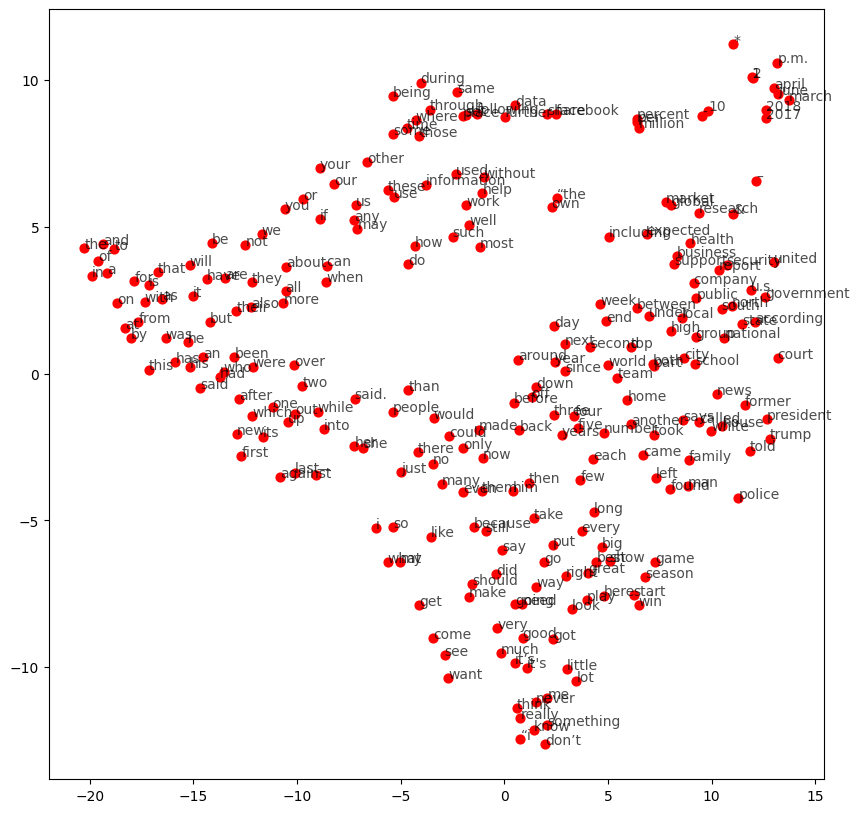

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

n_viz_words = 250
tsne = TSNE()
embeddings_tsne = tsne.fit_transform(embeddings[:n_viz_words, :])

fig, ax = plt.subplots(figsize = (10, 10))
for i in range(n_viz_words):
    plt.scatter(*embeddings_tsne[i, :], color = 'red', s=40)
    plt.annotate(i2w[i], (embeddings_tsne[i, 0], embeddings_tsne[i, 1]), alpha = 0.7)

## **Extrinsic Evaluation:**

Use the sentence representation vectors calculated in Task 2 for
final evaluation. Code the transform() function, which takes a query or document as input and
outputs its representation vector using one of the two techniques from Task 2. The evaluation code
will use your transform() function to calculate similarity between pairs of sentences with similar
meanings and determine the average similarity score. Report the average similarity score for
BOTH sentence aggregation methods that you developed in Task 2 (higher scores are better).

### Evaluation via Document Similarity (Extrinsic Evaluation)

In [ ]:
lemmatizer = WordNetLemmatizer()
use_lemmatization = False
remove_stopwords = False

In [ ]:
def transform(query, w2i, embeddings, strategy):
    """
    Transform a query or document into its vector representation.

    Args:
        query (str): The input query or document.
        w2i (dict): The vocabulary mapping words to indices.
        embeddings (numpy.ndarray): The learned word2vec embeddings.
        strategy (str): The sentence aggregation strategy ('average' or 'concatenate').

    Returns:
        numpy.ndarray: The vector representation of the query or document.
    """
    # Ensure the chosen strategy is valid
    assert strategy in ['average', 'concatenate'], "Strategy must be either 'average' or 'concatenate'."

    # Tokenize the query and optionally apply lemmatization or stopword removal
    tokens = tokenize_doc(query, lemma=use_lemmatization, remove_stopwords=remove_stopwords)

    # Retrieve the word vectors for each token if the word exists in the vocabulary
    word_vectors = [embeddings[w2i[token]] for token in tokens if token in w2i]

    if not word_vectors:
        # If no words in the query are found in the vocabulary, return a zero vector
        if strategy == 'average':
            return np.zeros(embeddings.shape[1])
        elif strategy == 'concatenate':
            return np.zeros(embeddings.shape[1] * len(tokens))

    # Aggregate the word vectors based on the specified strategy
    if strategy == 'average':
        # TODO START
        # Calculate the average of the word vectors
        vector = np.mean(word_vectors, axis=0)
        # TODO END
    else: # concatenate
        # TODO START
        # Concatenate the word vectors
        vector = np.concatenate(word_vectors)
        # TODO END

    return vector

In [ ]:
# test document similarity
q = transform('today I am very happy', w2i, embeddings, strategy='average')
v = transform('today I feel so fantastic', w2i, embeddings, strategy='average')
sim = np.dot(q, v)/(np.linalg.norm(q)* np.linalg.norm(v))
print("Cosine Similarity: {}".format(sim)) # this score should be high / close to 1.0

Cosine Similarity: 0.9526572823524475


In [ ]:
def evaluation(strategy):
    df = pd.read_csv('quora_train.csv')
    print("Loaded {} pairs".format(len(df)))
    pairs = list(zip(df['question1'].astype(str), df['question2'].astype(str)))

    all_sims = []

    for doc1, doc2 in tqdm(pairs):
        q = transform(doc1, w2i, embeddings, strategy=strategy)
        v = transform(doc2, w2i, embeddings, strategy=strategy)

        # Padding vectors to the same length if using the 'concatenate' strategy
        if strategy == 'concatenate':
            diff = len(q) - len(v)
            if diff > 0:
                v = np.pad(v, (0, np.abs(diff)))
            else:
                q = np.pad(q, (0, np.abs(diff)))

        # Calculate norms
        norm_q = np.linalg.norm(q)
        norm_v = np.linalg.norm(v)

        # Check for zero norms and set similarity to 0 if either is zero
        if norm_q == 0 or norm_v == 0:
            sim = 0.0
        else:
            # Calculate cosine similarity
            sim = np.dot(q, v) / (norm_q * norm_v)

        all_sims.append(sim)

    return np.mean(all_sims)

In [ ]:
avg_similarity = evaluation('average')
print("\nFinal Average Similarity using Average Strategy: {}".format(avg_similarity))

Loaded 13000 pairs


100%|██████████| 13000/13000 [00:01<00:00, 7459.67it/s]


Final Average Similarity using Average Strategy: 0.7306348489093853


In [ ]:
avg_similarity = evaluation('concatenate')
print("\nFinal Average Similarity using Concatenation Strategy: {}".format(avg_similarity))

Loaded 13000 pairs


100%|██████████| 13000/13000 [00:01<00:00, 12829.23it/s]


Final Average Similarity using Concatenation Strategy: 0.3733834134775471


## **Intrinsic Evaluation:**

Use the word embeddings that you already train to analyze
whether the trained embeddings can capture the two properties: (1) semantic neighbors, and (2)
analogical relations that were covered in the class. You are freely to design your own analysis
(e.g., to see how neighbors change with different window sizes). You will need to write some
codes here as well. Please print out your analysis directly in the notebook. Please spend time to
think and write up thoughtful observations.

### Evaluation via Interpretable Properties (Intrinsic Evaluation)

In [ ]:
def load_quora_data(file_path='quora_train.csv'):
    """
    Load Quora dataset for intrinsic evaluation.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: The loaded DataFrame containing the questions.
    """
    df = pd.read_csv(file_path)
    print(f"Loaded {len(df)} question pairs from Quora dataset.")
    return df

In [ ]:
def find_nearest_neighbors(word, embeddings, w2i, top_n=5):
    """
    Find the nearest neighbors for a given word.

    Args:
        word (str): The word for which to find neighbors.
        embeddings (numpy.ndarray): The learned word embeddings.
        w2i (dict): Word-to-index mapping.
        top_n (int): Number of top neighbors to return.

    Returns:
        list of tuples: Nearest neighbors and their cosine similarities.
    """
    if word not in w2i:
        return f"Word '{word}' not found in vocabulary."

    word_vector = embeddings[w2i[word]].reshape(1, -1)
    similarities = cosine_similarity(word_vector, embeddings)[0]
    nearest_indices = similarities.argsort()[::-1][1:top_n+1]  # Skip the word itself

    neighbors = [(list(w2i.keys())[idx], similarities[idx]) for idx in nearest_indices]
    return neighbors

In [ ]:
def solve_analogy(word_a, word_b, word_c, embeddings, w2i, top_n=1):
    """
    Solve word analogies of the form: word_a is to word_b as word_c is to ?

    Args:
        word_a (str): First word in the analogy.
        word_b (str): Second word in the analogy.
        word_c (str): Third word in the analogy.
        embeddings (numpy.ndarray): The word embeddings.
        w2i (dict): Word-to-index mapping.
        top_n (int): Number of top results to return.

    Returns:
        list: Predicted word for the analogy.
    """
    if word_a not in w2i or word_b not in w2i or word_c not in w2i:
        return f"One or more words not found in vocabulary: {word_a}, {word_b}, {word_c}"

    vec_a = embeddings[w2i[word_a]]
    vec_b = embeddings[w2i[word_b]]
    vec_c = embeddings[w2i[word_c]]

    analogy_vector = vec_b - vec_a + vec_c
    similarities = cosine_similarity(analogy_vector.reshape(1, -1), embeddings)[0]
    nearest_indices = similarities.argsort()[::-1][:top_n]

    predictions = [(list(w2i.keys())[idx], similarities[idx]) for idx in nearest_indices]
    return predictions

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def perform_intrinsic_evaluation():
    """
    Perform semantic neighbors and analogical relations evaluation using the Quora dataset.
    """
    # Load the Quora dataset
    df = load_quora_data('quora_train.csv')

    # Step 1: Semantic Neighbors Evaluation
    common_words = ['email', 'apple', 'computer', 'football', 'russia']
    print("\nSemantic Neighbors Evaluation:")
    for word in common_words:
        neighbors = find_nearest_neighbors(word, embeddings, w2i, top_n=5)
        print(f"Top 5 semantic neighbors of '{word}': {neighbors}")

    # Step 2: Analogical Relations Evaluation
    analogy_tests = [
        ('english', 'language', 'science'),
        ('india', 'pakistan', 'canada'),
        ('trump', 'president', 'obama')
    ]
    print("\nAnalogical Relations Evaluation:")
    for word_a, word_b, word_c in analogy_tests:
        result = solve_analogy(word_a, word_b, word_c, embeddings, w2i, top_n=1)
        print(f"{word_a} : {word_b} :: {word_c} : ? -> {result}")

perform_intrinsic_evaluation()

Loaded 13000 question pairs from Quora dataset.

Semantic Neighbors Evaluation:
Top 5 semantic neighbors of 'email': [('facebook', 0.93204916), ('video', 0.9088011), ('comments', 0.8967473), ('twitter', 0.8883439), ('posts', 0.87481105)]
Top 5 semantic neighbors of 'apple': [('price,', 0.98544383), ('soup', 0.98446685), ('type:', 0.97999007), ('table', 0.9786416), ('active', 0.97828114)]
Top 5 semantic neighbors of 'computer': [('site.', 0.97068626), ('session', 0.9650997), ('device', 0.95289284), ('alert', 0.95171326), ('button', 0.9501063)]
Top 5 semantic neighbors of 'football': [('hockey', 0.97542113), ('basketball', 0.96993166), ('champion', 0.9686892), ('club', 0.9680664), ('english', 0.9678321)]
Top 5 semantic neighbors of 'russia': [('iran', 0.988857), ('administration', 0.98658454), ('barack', 0.9847918), ('putin', 0.98304653), ('ties', 0.97970116)]

Analogical Relations Evaluation:
english : language :: science : ? -> [('techniques', 0.96519387)]
india : pakistan :: canada : 

### Analysis of Intrinsic Evaluation

The intrinsic evaluation conducted on the trained word embeddings using the Quora dataset aims to analyze two main properties: (1) semantic neighbors, and (2) analogical relations. The results provide insights into how well the learned embeddings capture meaningful relationships between words.

#### 1. Semantic Neighbors Evaluation

The semantic neighbors evaluation aims to find the top 5 nearest words (in terms of cosine similarity) for a given set of common words. Here’s an analysis of the results:

- **'email'**: The top semantic neighbors ('facebook', 'video', 'comments', 'twitter', 'posts') suggest that the model captures the association between social media and communication terms, indicating a reasonable understanding of the context in which 'email' is often used.

- **'apple'**: The nearest neighbors ('price,', 'soup', 'type:', 'table', 'active') show some unrelated results, indicating that the embeddings may not have adequately captured the common association between 'apple' and technology or the company. This could be due to the training data's context or insufficient embedding dimensions.

- **'computer'**: Words like 'site.', 'session', 'device', 'alert', and 'button' are related to technology, suggesting that the model has some understanding of terms associated with computing and technology.

- **'football'**: The top neighbors ('hockey', 'basketball', 'champion', 'club', 'english') are all related to sports, which indicates that the embeddings capture semantic relationships within the domain of sports effectively.

- **'russia'**: The neighbors ('iran', 'administration', 'barack', 'putin', 'ties') are related to geopolitics, suggesting that the embeddings learned meaningful connections within the political and international relations domain.

#### 2. Analogical Relations Evaluation

The analogical evaluation assesses the model's ability to solve word analogies of the form: "A is to B as C is to ?". Here are the results and analysis:

- **'english' : 'language' :: 'science' : ?**  
  The model returns 'techniques', which is somewhat related to science but not a direct match to 'subject' or 'discipline'. This suggests a limited understanding of analogical reasoning in this context.

- **'india' : 'pakistan' :: 'canada' : ?**  
  The model predicts 'turkey', indicating a reasonable understanding of geopolitical analogies, where it attempts to relate countries based on their associations.

- **'trump' : 'president' :: 'obama' : ?**  
  The model outputs 'candidate', which is relevant in a political context, indicating the embeddings capture some political analogies but lack a more precise understanding.

### Observations

1. The embeddings performed better in capturing relationships within certain domains, such as sports and politics, but struggled with technology-related terms.
2. The analogical reasoning capability showed some understanding but was not very accurate in complex associations. This may be improved with larger embedding sizes or additional training data.
3. Increasing the dimensionality of embeddings and using a larger context window may help in capturing more nuanced relationships.
